In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
from pathlib import Path
from google.colab import drive
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Connection With Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unrar x '/content/drive/MyDrive/ML/Dataset(shapes).rar'

In [ ]:
def convertDfIndexToTuple (df) :
   # استخراج Index ستون‌ها
  columns_index = df.columns

  # تبدیل Index به لیست
  columns_list = columns_index.tolist()

  # تبدیل لیست به tuple
  columns_tuple = tuple(columns_list)

  return columns_tuple


In [17]:
file_path = '/content/drive/MyDrive/ML/images_and_labels.csv'

df = pd.read_csv(file_path)
print(f'data frame shape {df.shape}')

df.head(10)



data frame shape (1000, 2)


,image_path,label
0,/content/combination_images/combination-0.png,"0,0,3"
1,/content/combination_images/combination-1.png,"0,0,3"
2,/content/combination_images/combination-10.png,"1,1,1"
3,/content/combination_images/combination-100.png,"2,1,0"
4,/content/combination_images/combination-101.png,"0,1,2"
5,/content/combination_images/combination-102.png,"0,1,2"
6,/content/combination_images/combination-103.png,"0,1,2"
7,/content/combination_images/combination-104.png,"1,0,0"
8,/content/combination_images/combination-105.png,"0,1,1"
9,/content/combination_images/combination-106.png,"0,0,3"


In [91]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [51]:
def convertStrLabelToTensor (label):
  split_label = label.split(',')
  numeric_labels = [int(label) for label in split_label]
  # تبدیل لیست به LongTensor
  labels_tensor = torch.tensor(numeric_labels, dtype = torch.float32)

  # بررسی شکل برچسب‌ها
  # print("Shape of labels:", labels_tensor.shape)  # باید torch.Size([3]) باشد
  return(labels_tensor)


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=710x710 at 0x7C13983D82B0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=692x692 at 0x7C13A04A9450>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=612x612 at 0x7C13983D8640>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=664x664 at 0x7C13983D8970>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x700 at 0x7C13983D8B80>


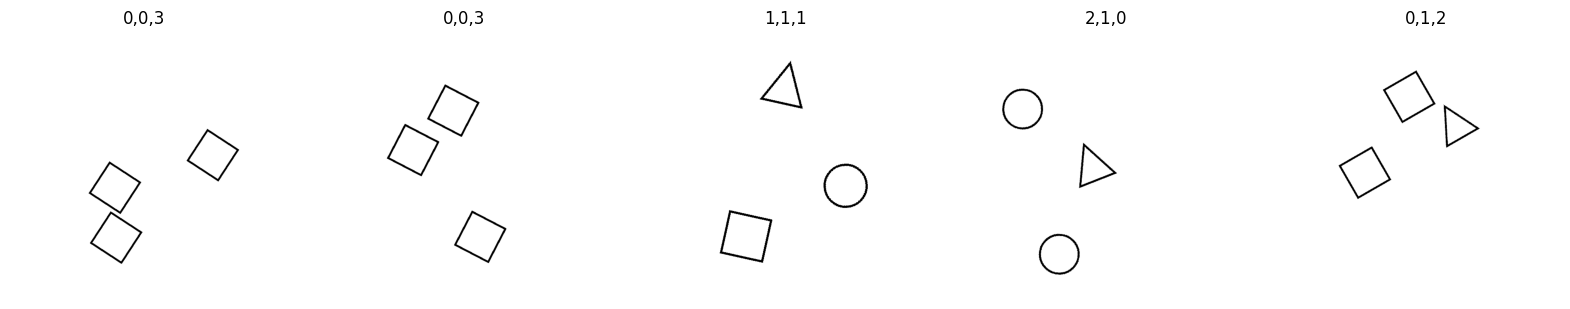

In [52]:

def show_images(df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        row = df.iloc[i]
        image = Image.open(row['image_path'])
        print(image)
        label = row['label']
        axes[i].imshow(np.squeeze(image),cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

show_images(df, num_images=5)

In [93]:
from sklearn import preprocessing

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        label=convertStrLabelToTensor(label= label)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label


In [94]:
# categories our data
BATCH_SIZE = 32

train_df , test_df = train_test_split(df, test_size = 0.2 ,shuffle=True)

print(f'Train_df shape {train_df.shape} , Test_df shape {test_df.shape}')

train_dataset = ImageDataset(train_df , transform = transform)
test_dataset = ImageDataset(test_df , transform = transform)

train_data_loader = DataLoader(train_dataset , batch_size = BATCH_SIZE , shuffle= True)
test_data_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE , shuffle = False)

print(f"Length of train dataloader: {len(train_data_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_data_loader)} batches of {BATCH_SIZE}")

# images, labels = next(iter(train_data_loader))


Train_df shape (800, 2) , Test_df shape (200, 2)
Length of train dataloader: 25 batches of 32
Length of test dataloader: 7 batches of 32


In [64]:
import torch
from torch import nn

# Create a convolutional neural network
class Shapes(nn.Module):
    def __init__(self):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # default stride value is same as kernel_size
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # default stride value is same as kernel_size
            nn.Linear(64*7*7*128),
            nn.Linear(128*3),
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*3969,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x


In [86]:
class ShapeCounterCNN(nn.Module):
    def __init__(self):
        super(ShapeCounterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 31 * 31, 128)
        self.fc2 = nn.Linear(128, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 31 * 31)  # تطبیق به شکل مناسب برای لایه تمام‌متصل
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [96]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [97]:
my_model =CNN()

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [104]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =my_model.parameters() , lr= 0.1)


In [35]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  acc = (correct / len(y_pred)) * 100
  return acc


In [105]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        model.train()
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 1. Forward pass
        y_pred = model(X)

        print(f'y_perd {y_pred.dtype} , y_target {y.dtype}')

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred) # Go from logits -> pred labels


        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.eval() # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [106]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs= 6
for epoch in tqdm(range(epochs)) :
  print(f"Epoch: {epoch}\n---------")
  train_step( model = my_model, data_loader = train_data_loader, loss_fn = loss_fn, optimizer = optimizer, accuracy_fn = accuracy_fn)
  test_step( model = my_model, data_loader = test_data_loader, loss_fn = loss_fn, accuracy_fn= accuracy_fn)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---------
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.float32 , y_target torch.float32
y_perd torch.fl

In [107]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob)

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [108]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({test_labels[0]})")

Test sample image shape: torch.Size([1, 64, 64])
Test sample label: tensor([0., 1., 2.]) (tensor([0., 1., 2.]))


In [109]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=my_model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[0.1757, 0.2774, 0.5469],
        [0.1757, 0.2774, 0.5469]])

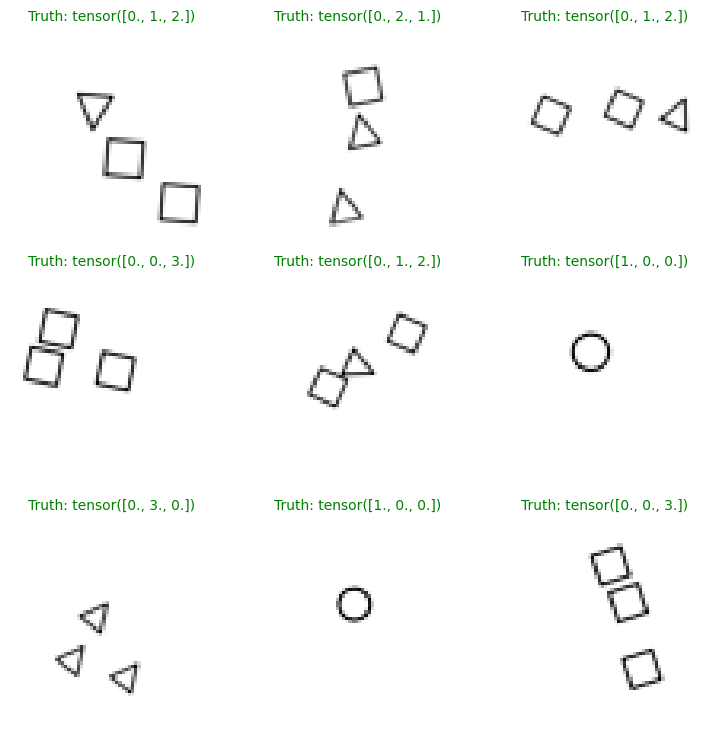

In [116]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  # pred_label = pred_classes[i]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = test_labels[i]

  # Create the title text of the plot
  title_text = f"Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  # if pred_label == truth_label:
  #     plt.title(title_text, fontsize=10, c="g") # green text if correct
  # else:
  plt.title(title_text, fontsize=10, c="g") # red text if wrong
  plt.axis(False);